In [1]:
from utils.vocabulary import Vocabulary
from utils.word2vec import Word2Vec
from RNN import RNN

import matplotlib.pyplot as plt
import numpy as np
import re

%matplotlib inline

# 1. Train word2vec

Before trying to predict the next word given a sequence, we need to obtain the word vector space using the word2vec algorithm. 

In [2]:
path = './data/timemachine.txt'

with open(path, 'r', encoding='utf-8') as f:
    file = f.read().strip().lower().split('\n')

words = []
for line in file:
    words += line.split(' ')
    
w2v = Word2Vec(Vocabulary(path), dim=300, window_size=2, 
               lr=0.02, random_state=10, K=2, 
               distribute=True)
print(len(words))

55308


Cost epoch 10th:  54742.545
Cost epoch 20th:  52844.697
Cost epoch 30th:  52297.205
Cost epoch 40th:  52585.584
Cost epoch 50th:  52186.292


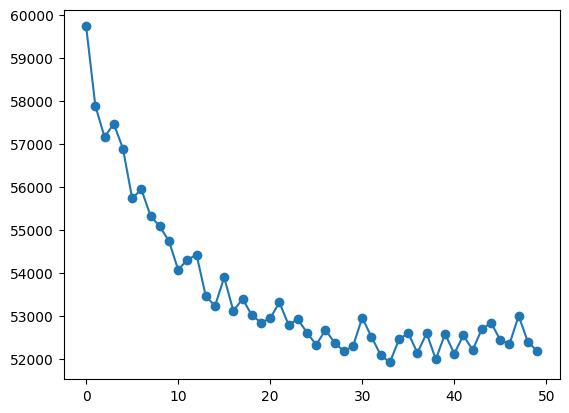

In [3]:
cost = []
max_words = 10_000
words = words[:max_words]

for j in range(50):
    total_loss = 0
    for i in range(w2v.window_size, len(words) - w2v.window_size):
        window = [words[i+j] for j in range(-w2v.window_size, w2v.window_size + 1) if j != 0]
        center_word = words[i]
        loss, n_s_i = w2v.forward(window, center_word)
        grads = w2v.backward(window, center_word, n_s_i)            
        w2v.update(grads)
        total_loss += loss 
    
    if not ((j + 1) % 10): print(f'Cost epoch {j+1}th: ', np.round(total_loss, decimals=3))
    cost.append(total_loss)

plt.plot(cost, '-o')
plt.show()

# 2. Next word prediction

1. Data preprocessing: input seq ---> target seq where the target seq is the input seq minus the first word, and the last word is the next word of the input seq. 

2. We want to apply a Many-to-One architecture, where the target word is the next word given a sequence. In order to do that, the Output layer must have a size of V, where V is the length of the vocabulary. 

3. To train we apply the softmax over the hole vocabulary using the softmax function as the output activation function, trying to maximize the probability of the target word. 

4. To predict, we apply a forward pass of a given sequence. The output will be the word whose probability is maximum. 

## 2.1 Utilities

We create some classes to make the preprocess and the training of the model more simple and easily tunned. 

In [4]:
class Dataset: 
    
    def __init__(self, inputs, outputs):
        self.inputs = inputs
        self.outputs = outputs
        
    def __len__(self):
        assert len(self.inputs) == len(self.outputs)
        return len(self.inputs)
    
    def __getitem__(self, index):
        assert isinstance(index, (list, int))
        if isinstance(index, int):
            return self.inputs[index], self.outputs[index]
        return [self.inputs[i] for i in index], [self.outputs[i] for i in index]

In [5]:
class Model: 
    
    def __init__(self, word_text, word2vec, length=5):
        """
        Parameters: 
        - word_text: list. 
                     List of the text we will use to train our model. 
        - word2vec: Word2Vec
                    Trained word2vec
        - length: int
                  How many past words we will use to predict the next one
        """
        self.words = word_text
        self.word2vec = word2vec
        self.sequence_length = length
        self.rnn = None
                
    def create_dataset(self):
        
        input_words, target_words = [], []
        input_vectors, output_vectors = [], []
        
        def one_hot(index):
            o_h = np.zeros((len(self.word2vec.vocabulary), 1))
            o_h[index] = 1
            return o_h
        
        for i in range(self.sequence_length, len(self.words) - self.sequence_length):
            input_seq = self.words[i: i + self.sequence_length]
            target_word = self.words[i + self.sequence_length]
            
            input_words.append(input_seq)
            target_words.append(target_word)
            
            input_vector_indexes = [self.word2vec.vocabulary[word] for word in input_seq]
            target_vector_indexes = self.word2vec.vocabulary[target_word]
                            
            input_vector = [self.word2vec.U[:, index] for index in input_vector_indexes]
            target_vector = one_hot(target_vector_indexes)
            
            input_vectors.append(input_vector)
            output_vectors.append(target_vector)
            
        self.word_dataset = Dataset(np.array(input_words), np.array(target_words))
        self.vector_dataset = Dataset(np.array(input_vectors), np.array(output_vectors))
            
        return self.word_dataset, self.vector_dataset
    
    def train_model(self, model, epochs=10):
        """
        Parameters: 
        - model: Recurrent Neural Network
        - epochs: int
        """
        
        dataset = self.vector_dataset
        
        cost = []
        print_ratio = epochs // 10
        
        for epoch in range(epochs):

            loss = 0

            for input_t, target_t in dataset:
                loss_t, predictions, outputs, hidden_outputs, hidden_states = model.forward(input_t, target_t)

                model.backward(input_t, target_t, predictions, outputs, hidden_outputs, hidden_states)
                model.update_weigths()
                
                loss += loss_t

            cost.append(loss)

            if not (epoch + 1) % print_ratio:
                print(f'Loss epoch {epoch + 1}th: ', np.round(loss, decimals=3))
                
        self.rnn = model
                
        return cost
    
    def predict(self, distribution=False):
        """
        Parameters: 
        - distribution: bool
                        If True, the next word will be drawn from the softmax distribution
                        If False, the next word will be the maximum argument of the softmax
        """
        predictions = []
        for input_seq, _ in self.vector_dataset:
            prediction = self.rnn.predict(input_seq)
            if distribution:
                max_prob_index = np.random.choice(len(prediction), p=prediction.ravel())
                predictions.append(max_prob_index)
            else:
                predictions.append(np.argmax(prediction))
            
        return predictions

## 2.2 Creation of the model object

In [19]:
model = Model(word_text=words[1000: 1400].copy(), word2vec=w2v, length=2)
words_dataset, vectors_dataset = model.create_dataset()
print('Total number of input and target sequences: ', len(words_dataset))
print(" ")

example = words_dataset[5]
input_seq_example = ''
for word in example[0]:
    input_seq_example += word + ' '

print('Example: ')
print('Input sequence: ', input_seq_example)
print('Target words: ', example[1])

Total number of input and target sequences:  396
 
Example: 
Input sequence:  of space 
Target words:  generally


## 2.3 RNN parameters and training

Loss epoch 10th:  0.374
Loss epoch 20th:  0.205
Loss epoch 30th:  0.148
Loss epoch 40th:  0.121
Loss epoch 50th:  0.11
Loss epoch 60th:  0.103
Loss epoch 70th:  0.097
Loss epoch 80th:  0.099
Loss epoch 90th:  0.097
Loss epoch 100th:  0.095


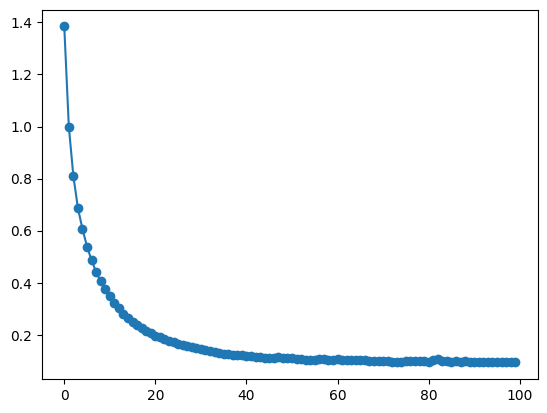

In [20]:
input_units = w2v.dim
output_units = len(w2v.vocabulary)
hidden_units = 80
learning_rate = 0.005

rnn = RNN(input_units=input_units, output_units=output_units, 
           lr=learning_rate, hidden_units=hidden_units, 
           dtype='many-to-one', cost_type='negative-log')

cost = model.train_model(rnn, epochs=100)
plt.plot(cost, '-o')
plt.show()

## 2.4 Prediction on the training set

In [34]:
predictions = model.predict(distribution=False)
correct_predictions = 0
n_examples = 10

for n, ((input_words, target_word), prediction) in enumerate(zip(words_dataset, predictions)):
    input_seq = ''
    for word in input_words:
        input_seq += word + ' '
    prediction_word = w2v.vocabulary[prediction]
        
    if target_word == prediction_word:
        correct_predictions += 1
    
    if n < n_examples:
        print('Input sequence: ', input_seq)
        print('Target word: ', target_word)
        print('Predicted word: ', prediction_word)
        print(" ")
        
print('Accuracy: ', str(np.round(correct_predictions / len(words_dataset), decimals=3) * 100) + '%')

Input sequence:  in any 
Target word:  of
Predicted word:  of
 
Input sequence:  any of 
Target word:  the
Predicted word:  the
 
Input sequence:  of the 
Target word:  dimensions
Predicted word:  unk
 
Input sequence:  the dimensions 
Target word:  of
Predicted word:  of
 
Input sequence:  dimensions of 
Target word:  space
Predicted word:  unk
 
Input sequence:  of space 
Target word:  generally
Predicted word:  generally
 
Input sequence:  space generally 
Target word:  recognized?
Predicted word:  unk
 
Input sequence:  generally recognized? 
Target word:  but
Predicted word:  but
 
Input sequence:  recognized? but 
Target word:  certainly
Predicted word:  a
 
Input sequence:  but certainly 
Target word:  it
Predicted word:  it
 
Accuracy:  60.4%


# 3. Test set

In [75]:
def predict(model, input_sequence, max_words=5):
    input_vector_indexes = [model.word2vec.vocabulary[word] for word in input_sequence]
    input_vector = [model.word2vec.U[:, index] for index in input_vector_indexes]
    prediction = model.rnn.predict(input_vector)
    indexes = np.argsort(prediction.ravel())[::-1][:max_words]
    return indexes

input_sequences = [['dimensions'], ['put', 'in'], ['they'], ['he', 'travel', 'with'], 
                   ['the', 'time', 'traveller'], ['made', 'of']]
for input_sequence in input_sequences:
    prediction = predict(model, input_sequence)
    phrase = ''
    for word in input_sequence:
        phrase += word + ' '
    print('Input sequence: ', phrase)
    print('Most probable words: ')
    for i, p in enumerate(prediction):
        print(f'{i+1}: ', model.word2vec.vocabulary[p])
    print(" ")

Input sequence:  dimensions 
Most probable words: 
1:  are
2:  but
3:  of
4:  the
5:  has
 
Input sequence:  put in 
Most probable words: 
1:  a
2:  two
3:  conclude
4:  course
5:  this
 
Input sequence:  they 
Most probable words: 
1:  but
2:  could
3:  districts
4:  unk
5:  whole
 
Input sequence:  he travel with 
Most probable words: 
1:  a
2:  from
3:  at
4:  getting
5:  along
 
Input sequence:  the time traveller 
Most probable words: 
1:  the
2:  of
3:  move
4:  unk
5:  our
 
Input sequence:  made of 
Most probable words: 
1:  the
2:  staying
3:  unk
4:  am
5:  time
 
